<a href="https://colab.research.google.com/github/barryhpr/SyntheticDebiasing/blob/main/Adapter_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#adapter transformer should be 3.2.1
!pip install transformers==4.26.1
!pip install -U adapter-transformers
# !pip install adapters
# !pip install transformers==4.33.1
!pip install datasets
!git clone https://github.com/barryhpr/SyntheticDebiasing.git
!python -m spacy download en_core_web_md
%cd /content/SyntheticDebiasing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
Cloning into 'SyntheticDebiasing'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (40/40), d

In [ ]:
import tokenizers
print(tokenizers.__version__)
import transformers
print(transformers.__version__)
import datasets
print(datasets.__version__)


0.13.3
4.26.1
2.15.0


In [ ]:
#import all libraries
import json
import spacy
import os
import shutil
import torch
import random
import numpy as np
import spacy
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForMaskedLM, TrainingArguments, Trainer
import matplotlib.pyplot as plt
from tqdm import tqdm

# Top and Lowest 50 Loss


This is an example of how to perform loss-guided prompting: you can filter the data with lower and higher loss as examples to guide the model in generating more in-distribution synthetic data.



Using device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Evaluating sentences: 100%|██████████| 500/500 [09:45<00:00,  1.17s/it]


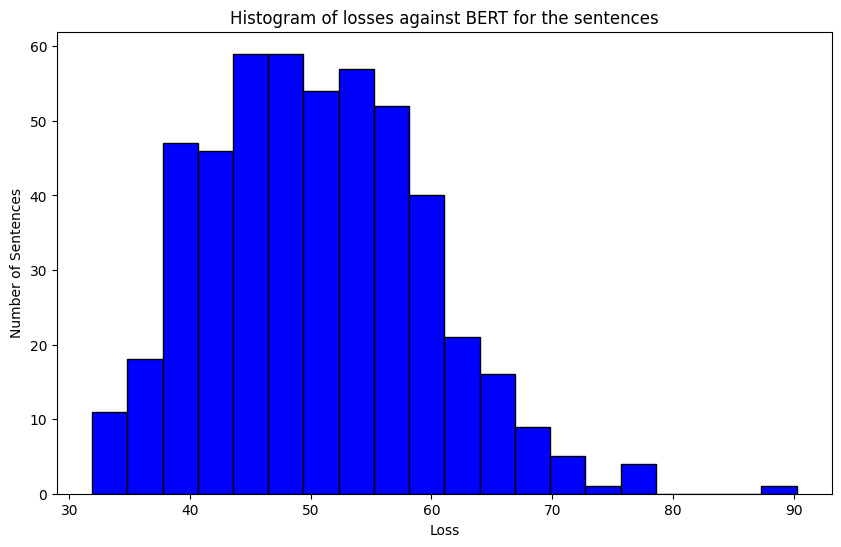

In [ ]:
import json
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForMaskedLM
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def calculate_sentence_loss(sentence, model, tokenizer):
    tokenized_input = tokenizer(sentence, return_tensors='pt')
    input_ids = tokenized_input['input_ids']
    mask = torch.zeros(input_ids.size(), dtype=torch.bool)
    total_loss = 0.0

    for i in range(input_ids.size(1)):
        mask[0, i] = True
        masked_input = input_ids.masked_fill(mask, tokenizer.mask_token_id)

        with torch.no_grad():
            outputs = model(masked_input, labels=input_ids)

        prediction_scores = outputs.logits
        masked_lm_loss = F.cross_entropy(prediction_scores.squeeze(0), input_ids.squeeze(0), reduction='none')
        total_loss += masked_lm_loss[i].item()
        mask[0, i] = False

    return total_loss

with open('Synthetic_General_1S.json', 'r') as f:
    data = json.load(f)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

losses = []
for item in tqdm(data, desc="Evaluating sentences"):
    sentence = item[0]
    loss = calculate_sentence_loss(sentence, model, tokenizer)
    losses.append(loss)

sorted_data_with_losses = sorted(zip(data, losses), key=lambda x: x[1])

highest_losses = [[item[0][0], item[0][1], item[0][2], item[1]] for item in sorted_data_with_losses[-50:]]
lowest_losses = [[item[0][0], item[0][1], item[0][2], item[1]] for item in sorted_data_with_losses[:50]]

with open('highest_general.json', 'w') as f:
    json.dump(highest_losses, f)

with open('lowest_general.json', 'w') as f:
    json.dump(lowest_losses, f)

plt.figure(figsize=(10,6))
plt.hist(losses, bins=20, color='blue', edgecolor='black')
plt.title('Histogram of losses against BERT for the sentences')
plt.xlabel('Loss')
plt.ylabel('Number of Sentences')
plt.show()


# Evaluate Original BERT Model

In [ ]:
from Score_evaluator import *
from Score_evaluator1_1 import *
from Evaluate_StereoSet import *
from Evaluate_CrowSPairs import *
from transformers import BertTokenizer, BertForMaskedLM, TrainingArguments, Trainer

eval_model1 = BertForMaskedLM.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

srunner = StereoSetRunner(
    intrasentence_model = eval_model1,
    tokenizer = tokenizer,
    # model_name = "gpt2",
    input_file="test.json",
    is_generative=False,
    is_self_debias=False
    )
metric_data = srunner() # a nested dict

import json
with open('stereoset_result.json', 'w') as outfile:
    json.dump(metric_data, outfile, indent=4)  # The `indent=4` makes the JSON output more readable

parse_file("test.json",'stereoset_result.json')

# Train BERT

In [ ]:
# makse sure to change the save-step (change to number of data in each epoc)

# Load the SpaCy model
nlp = spacy.load("en_core_web_md")

# Load the data
# This is Bert:
# So for Targeted, please load Synthetic_Category_#S
# For General, please load Synthetic_General_#S


#Adjust dataset, learning rate,and epoch accordingly

with open('Synthetic_Gender_1S.json', 'r') as file:
    data = json.load(file)

# Function to find most similar word in the sentence to the attribute
def most_similar(word, sentence):
    similarities = [nlp(word).similarity(nlp(token.text)) for token in sentence]
    most_similar_index = similarities.index(max(similarities))
    return sentence[most_similar_index].text

# Mask the attribute words
masked_data = []
for item in data:
    sentence, subject, attribute = item
    doc = nlp(sentence)
    if attribute in sentence:
        masked_sentence = sentence.replace(attribute, '[MASK]')
        masked_data.append([masked_sentence, subject, attribute])
    else:
        most_similar_word = most_similar(attribute, doc)
        masked_sentence = sentence.replace(most_similar_word, '[MASK]')
        masked_data.append([masked_sentence, subject, most_similar_word])

# Write the output to a new file
with open('Mask.json', 'w') as file:
    json.dump(masked_data, file, indent=4)

# Function to set the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Custom Dataset
class MyDataset(Dataset):
    def __init__(self, filename, tokenizer):
        with open(filename, 'r') as file:
            self.data = json.load(file)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item[0].replace("[MASK]", tokenizer.mask_token)
        encoding = self.tokenizer(text, return_tensors='pt')
        labels = encoding['input_ids'].clone()
        mask_idx = torch.where(labels == tokenizer.mask_token_id)[1]
        labels[labels != tokenizer.mask_token_id] = -100
        return {'input_ids': encoding['input_ids'].squeeze(), 'attention_mask': encoding['attention_mask'].squeeze(), 'labels': labels.squeeze(), 'mask_idx': mask_idx}

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = MyDataset('Mask.json', tokenizer)
test_dataset = MyDataset('test.json', tokenizer)

# Remove existing results directory and create a new one
if os.path.exists('./results'):
    shutil.rmtree('./results')
os.makedirs('./results')

# Training session
training_epoch = 5
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.add_adapter("debias")
model.train_adapter("debias")

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=training_epoch,
    per_device_train_batch_size=1,
    logging_steps=10,
    save_steps = 300,
    seed=42,
    # learning_rate=1e-7,
    learning_rate=1e-5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 300
  Num Ep

Step,Training Loss
10,17.779300
20,16.268900
30,18.002200
40,16.697900
50,15.375300
60,16.228800
70,15.959500
80,16.025400
90,15.868500
100,15.862100


Saving model checkpoint to ./results/checkpoint-300
Configuration saved in ./results/checkpoint-300/config.json
Configuration saved in ./results/checkpoint-300/generation_config.json
Model weights saved in ./results/checkpoint-300/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-600
Configuration saved in ./results/checkpoint-600/config.json
Configuration saved in ./results/checkpoint-600/generation_config.json
Model weights saved in ./results/checkpoint-600/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-900
Configuration saved in ./results/checkpoint-900/config.json
Configuration saved in ./results/checkpoint-900/generation_config.json
Model weights saved in ./results/checkpoint-900/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1200
Configuration saved in ./results/checkpoint-1200/config.json
Configuration saved in ./results/checkpoint-1200/generation_config.json
Model weights saved in ./results/checkpoint-1200/pytorch_model.bin


TrainOutput(global_step=1500, training_loss=5.998236571470897, metrics={'train_runtime': 83.874, 'train_samples_per_second': 17.884, 'train_steps_per_second': 17.884, 'total_flos': 11173134352680.0, 'train_loss': 5.998236571470897, 'epoch': 5.0})

# Evaluate BERT
1.   Eval on StereoSet
2.   Eval on CrowSPairs



In [ ]:
# Evaluation session
from Score_evaluator import *
from Score_evaluator1_1 import *
from Evaluate_StereoSet import *
from Evaluate_CrowSPairs import *
from transformers import GPT2LMHeadModel, BertTokenizer, BertForMaskedLM

evaluation_list = [2]
for eval_epoch in evaluation_list:

    print(f"Evaluate epoch{eval_epoch}")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    checkpoint_path = f"/content/SyntheticDebiasing/results/checkpoint-{eval_epoch*300}"
    eval_model = BertForMaskedLM.from_pretrained(checkpoint_path)
    eval_model.set_active_adapters("debias")

    srunner = StereoSetRunner(
        intrasentence_model = eval_model,
        tokenizer = tokenizer,
        input_file="test.json",
        is_generative=False,
        is_self_debias=False
        )
    metric_data = srunner() # a nested dict

    import json
    with open('stereoset_result.json', 'w') as outfile:
        json.dump(metric_data, outfile, indent=4)  # The `indent=4` makes the JSON output more readable

    parse_file("test.json",'stereoset_result.json')

    ##########################################################
    # To evaluate only on one category change parse_file (don't use test.json)
    # srunner = StereoSetRunner(
    #     intrasentence_model = eval_model,
    #     tokenizer = tokenizer,
    #     input_file="test-religion.json",
    #     is_generative=False,
    #     is_self_debias=False
    #     )

    # metric_data = srunner() # a nested dict

    # import json
    # with open('stereoset_result.json', 'w') as outfile:
    #     json.dump(metric_data, outfile, indent=4)  # The `indent=4` makes the JSON output more readable

    # parse_file1("test.json", 'stereoset_result.json', "religion")



    #########################################################

    runner = CrowSPairsRunner(
            model=eval_model,
            tokenizer=tokenizer,
            input_file="crows_pairs_anonymized.csv",
            bias_type="race", # change here for other categories
            is_generative=False
        )

    results = runner()
    print(f"Metric Score: {results}")
    print(" ")



# Evaluate BERT on BiasTestGPT

In [ ]:
import json
from transformers import BertTokenizer, BertForMaskedLM
import torch
import numpy as np

def sentence_to_template(sentence, target, mask_token="[MASK]"):
    return sentence.replace(target, mask_token, 1)

def get_mask_idx(token_ids, mask_token_id):
    mask_positions = torch.where(token_ids == mask_token_id)
    if len(mask_positions[0]) == 0:
        raise ValueError("No MASK token found in the input!")
    return mask_positions[0][0].item()  # Take the first occurrence of the MASK token

def getBERTProbPairs(model, tokenizer, sentences, targets, device, verbose=False):
    target_probs = []
    tested_sentences = []

    for ti, (sentence, target) in enumerate(zip(sentences, targets)):
        template = sentence_to_template(sentence, target, mask_token="[MASK]")
        if verbose:
            print(f"Template: {template}")

        prior_token_ids = tokenizer.encode(template, add_special_tokens=True, return_tensors="pt").to(device)
        prior_logits = model(prior_token_ids)
        targ_id = tokenizer.encode(target, add_special_tokens=False)[0]
        logits = prior_logits[0][0][get_mask_idx(prior_token_ids[0], tokenizer.mask_token_id)][targ_id]
        target_probs.append(logits.item())
        tested_sentences.append(template.replace("[MASK]", target))

    return target_probs, tested_sentences

#### Change Dataset for Different Categories ####
# Formatted_Profession_vs_Gender
# Formatted_Math_Arts_vs_Male_Female
# Formatted_Science_Arts_vs_Male_Female
# Formatted_Career_Family_vs_MaleName_FemaleName
# Formatted_YoungName_OldName_vs_Pleasant_Unpleasant.json
with open('Formatted_Profession_vs_Gender.json', 'r') as file:
    data = json.load(file)

evaluation_list = [1]
for eval_epoch in evaluation_list:
    print(f"Evaluate epoch{eval_epoch}")

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    checkpoint_path = f"/content/SyntheticDebiasing/results/checkpoint-{eval_epoch*500}"
    model = BertForMaskedLM.from_pretrained(checkpoint_path)
    model.set_active_adapters("debias")

    stereo_count = 0
    total_count = 0
    errors = []
    multi_occurrences = []

    for entry in data:
        sentence = entry['sentence']
        alt_sentence = entry['alt_sentence']
        grp_term1 = entry['grp_term1']
        grp_term2 = entry['grp_term2']

        if grp_term1 not in sentence or grp_term2 not in alt_sentence:
            errors.append((grp_term1, sentence, grp_term2, alt_sentence))
            continue

        if sentence.count(grp_term1) > 1 or alt_sentence.count(grp_term2) > 1:
            multi_occurrences.append((grp_term1, sentence, grp_term2, alt_sentence))
            continue

        logits_grp_term1, _ = getBERTProbPairs(model, tokenizer, [sentence], [grp_term1], 'cpu')
        logits_grp_term2, _ = getBERTProbPairs(model, tokenizer, [alt_sentence], [grp_term2], 'cpu')

        if entry['label_1'] == 'stereotype' and logits_grp_term1[0] > logits_grp_term2[0]:
            stereo_count += 1
        elif entry['label_1'] == 'anti-stereotype' and logits_grp_term2[0] > logits_grp_term1[0]:
            stereo_count += 1

        total_count += 1

    percentage = (stereo_count / total_count) * 100
    print(f'Stereotype Percentage for epoch {eval_epoch}: {percentage}%')
    print(f'Total cases with missing terms for epoch {eval_epoch}: {len(errors)}')
    print(f'Total cases with multiple occurrences of terms for epoch {eval_epoch}: {len(multi_occurrences)}')
